# G2NET: Pytorch+Generated Realistic Noise


## TL;DR

As it was found in [**G2Net: Winning Strategy with External Data**
](https://www.kaggle.com/code/vslaykovsky/g2net-winning-strategy-with-external-data), 20% of all test samples were generated from data comming from real detectors L1 and H1. E.g. organizers took real samples of real noise and overlayed generated signals. Unfortunately, the training set only contains generated noise, so there is an inevitable distribution shift between train and test samples. This notebook targets this specific problem.

In this notebook we use noise generated in [**G2NET: Realistic Simulation of Test Noise**](https://www.kaggle.com/code/vslaykovsky/g2net-realistic-simulation-of-test-noise), combine it with [pure signal](https://www.kaggle.com/code/vslaykovsky/g2net-generating-pure-signal) to produce synthetic data.
This synthetic data is then used to train a better model for the 20% of "real" test samples. 

The output is then combined with the best public solution to improve LB score. 


## Notes:

* For details on how noise and signal are combined refer to `RealisticNoiseDataset`. We use a simple weighted sum. Additionally we use gaussian noise to mitigate overfitting. 
* Optuna is used for hyperparameter tuning. 
* 5 folds model is trained for ensemble inference. 


**Smash that like button and subscribe for more eye-popping notebooks!**

## Utils

In [1]:
!pip install -q timm

In [2]:
!pip install -q git+https://github.com/PyFstat/PyFstat@python37

In [3]:
from timm.data.transforms_factory import create_transform
import torchvision
from torch.utils.data import Dataset
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import timm
import torch
from sklearn.metrics import *
from tqdm import tqdm
import gc
import wandb
import os
import pandas as pd
import re

BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    WANDB_API_KEY = user_secrets.get_secret("WANDB_API_KEY")
    os.environ['WANDB_API_KEY'] = WANDB_API_KEY
    NOISE_DIR = '/kaggle/input/realistic-noise-256/data/realistic_noise/images/'
    SIGNAL_DIR = '/kaggle/input/g2net-pure-signal/pure_signal'
    
except:
    print('Running locally')
    NOISE_DIR = 'data/realistic_noise/images/'
    SIGNAL_DIR = 'data/pure_signal/'
    os.environ['WANDB_API_KEY'] = 'your_key_here'
    
POSITIVE_RATE = 0.5
SIGNAL_LOW = 0.02
SIGNAL_HIGH = 0.10
EVAL_PCT = 0.2
DEBUG = True
OPTUNA = False
TRAIN = True
FOLDS = [0, 1, 2, 3, 4]
# FOLDS = [0] 
N_FOLDS = 5

# class Config:
LR = 0.00056
DROPOUT = 0.25
MAX_GRAD_NORM = 1.36
EPOCHS = 3
GAUSSIAN_NOISE = 2.
ONE_CYCLE_PCT_START=0.1
MODEL = 'efficientnet_b1'
ONE_CYCLE = True

WANDB_RUN = f'{MODEL}-LR:{LR}-DR:{DROPOUT}-E:{EPOCHS}-MGN:{MAX_GRAD_NORM}-NOISE:{GAUSSIAN_NOISE}-OC:{int(ONE_CYCLE)}-OCPS:{ONE_CYCLE_PCT_START}'
WANDB_RUN

'efficientnet_b1-LR:0.00056-DR:0.25-E:3-MGN:1.36-NOISE:2.0-OC:1-OCPS:0.1'

## Dataset

## Loading realistic noise

In [4]:
df_noise = pd.DataFrame(data=[[f] + list(re.findall('.*/([^/]*)/([^/]*).png', f)[0]) for f in glob.glob(f'{NOISE_DIR}/*/*.png')], columns=['name', 'id', 'detector']).sort_values(['id', 'detector'])
df_noise = df_noise.groupby('id').filter(lambda df: len(df) == 2).groupby('id', sort=False).apply(lambda df: df['name'].values).to_frame('files').reset_index()
df_noise_train, df_noise_eval = np.array_split(df_noise, [int(len(df_noise) * 0.9)])
df_noise

id                                              files
0     004f1b282  [/kaggle/input/realistic-noise-256/data/realis...
1     006e25113  [/kaggle/input/realistic-noise-256/data/realis...
2     008ec5560  [/kaggle/input/realistic-noise-256/data/realis...
3     00948246a  [/kaggle/input/realistic-noise-256/data/realis...
4     0112d6cc3  [/kaggle/input/realistic-noise-256/data/realis...
...         ...                                                ...
1491  fe6f5a121  [/kaggle/input/realistic-noise-256/data/realis...
1492  fecaed870  [/kaggle/input/realistic-noise-256/data/realis...
1493  ff771a983  [/kaggle/input/realistic-noise-256/data/realis...
1494  ff7f1c8ba  [/kaggle/input/realistic-noise-256/data/realis...
1495  fffa17f67  [/kaggle/input/realistic-noise-256/data/realis...

[1496 rows x 2 columns]

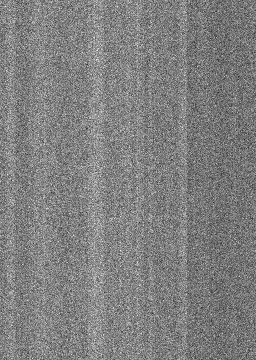

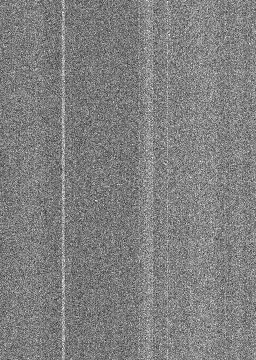

In [5]:
if DEBUG:
    f1, f2 = df_noise.iloc[42].files
    display(Image.open(f1))
    display(Image.open(f2))

## Loading pure signal

In [6]:
df_signal = pd.DataFrame(data=[[f] + list(re.findall('.*/(.*)_(.*).png', f)[0]) for f in glob.glob(f'{SIGNAL_DIR}/*')], columns=['name', 'id', 'detector']).sort_values(['id', 'detector'])
df_signal = df_signal.groupby('id').filter(lambda df: len(df) == 2).groupby('id', sort=False).apply(lambda df: df['name'].values).to_frame('files').reset_index()
df_signal_train, df_signal_eval = np.array_split(df_signal, [int(len(df_signal) * 0.9)])
df_signal

id                                              files
0     00000  [/kaggle/input/g2net-pure-signal/pure_signal/0...
1     00001  [/kaggle/input/g2net-pure-signal/pure_signal/0...
2     00002  [/kaggle/input/g2net-pure-signal/pure_signal/0...
3     00003  [/kaggle/input/g2net-pure-signal/pure_signal/0...
4     00004  [/kaggle/input/g2net-pure-signal/pure_signal/0...
...     ...                                                ...
9550  09995  [/kaggle/input/g2net-pure-signal/pure_signal/0...
9551  09996  [/kaggle/input/g2net-pure-signal/pure_signal/0...
9552  09997  [/kaggle/input/g2net-pure-signal/pure_signal/0...
9553  09998  [/kaggle/input/g2net-pure-signal/pure_signal/0...
9554  09999  [/kaggle/input/g2net-pure-signal/pure_signal/0...

[9555 rows x 2 columns]

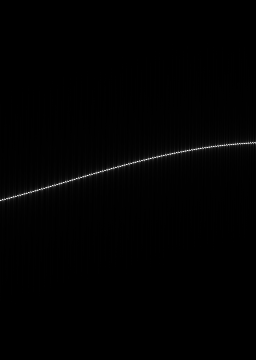

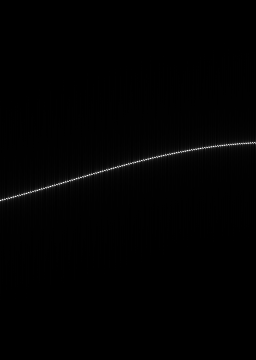

In [7]:
if DEBUG:
    f1, f2 = df_signal.iloc[42].files
    display(Image.open(f1))
    display(Image.open(f2))

## RealisticNoiseDataset

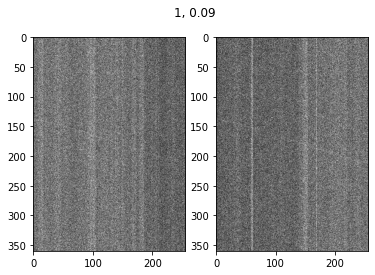

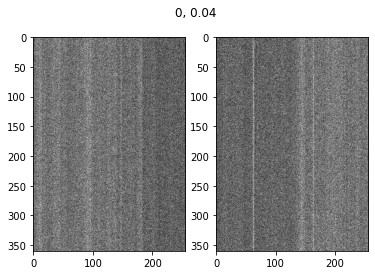

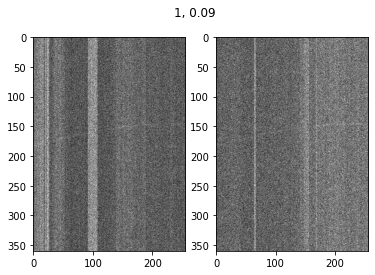

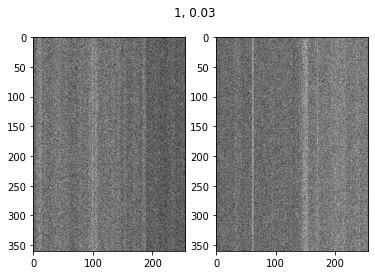

In [8]:
from collections import defaultdict
import re

def get_transforms():
    return torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=0.5, std=0.1)
        ])

class RealisticNoiseDataset(Dataset):
    def __init__(self, size, df_noise, df_signal, positive_rate=POSITIVE_RATE, is_train=False) -> None:
        self.df_noise = df_noise
        self.df_signal = df_signal
        self.positive_rate = positive_rate
        self.size = size
        self.transforms = get_transforms()
        self.is_train = is_train


    def gen_sample(self, signal, noise, signal_strength):
        # print(signal, noise)
        noise = np.array(Image.open(noise))
        # print(np.mean(noise.flatten() / 255), np.std(noise.flatten()/ 255))
        if signal:
            signal = np.array(Image.open(signal))
            noise = noise + signal_strength * signal

        if self.is_train and GAUSSIAN_NOISE > 0:
            noise = noise + np.random.randn(*noise.shape) * GAUSSIAN_NOISE 

        noise = np.clip(noise, 0, 255).astype(np.uint8)
        return self.transforms(noise)


    def __getitem__(self, index):
        noise_files = self.df_noise.sample().files.values[0]
        
        sig_files = [None, None]
        label = 0
        if np.random.random() < self.positive_rate:
            sig_files = self.df_signal.sample().files.values[0]
            label = 1
        signal_strength = np.random.uniform(SIGNAL_LOW, SIGNAL_HIGH)                    
        return np.concatenate([self.gen_sample(sig, noise, signal_strength) for sig, noise in zip(sig_files, noise_files)], axis=0), label, signal_strength


    def __len__(self):
        return self.size



ds_eval = RealisticNoiseDataset(
    len(df_signal_eval), 
    df_noise_eval,
    df_signal_eval
)
dl_eval = torch.utils.data.DataLoader(ds_eval, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), pin_memory=True)

if DEBUG:
    for i in range(4):
        X, y, ss = ds_eval[i]
        plt.figure()
        plt.suptitle(f'{y}, {ss:.02f}')
        plt.subplot(121).imshow(X[0], cmap='gray')
        plt.subplot(122).imshow(X[1], cmap='gray')

## Evaluation

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth
Eval: 100%|██████████| 30/30 [00:14<00:00,  2.12it/s]


0.49349943930473783 0.46797555685043335


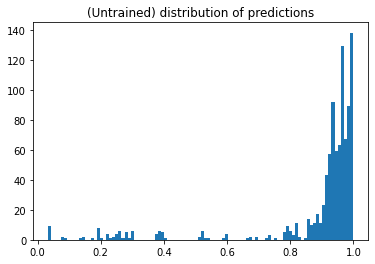

In [9]:
def evaluate(model, dl_eval, return_X=False):
    with torch.no_grad():
        model.eval()
        pred = []
        target = []
        ss = []
        signal_strength = []
        Xs = []
        for X, y, ss in tqdm(dl_eval, desc='Eval'):
            pred.append(model(X.to(DEVICE)).cpu().squeeze())
            target.append(y)
            signal_strength.append(ss)
            if return_X:
                Xs.append(X)
        pred = torch.concat(pred)
        target = torch.concat(target)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(pred, target.float(), reduction='none').median().item() # Avoiding outlier loss with median
        pred = torch.sigmoid(pred)
        ret = [roc_auc_score(target, pred), loss, pred, target, torch.concat(signal_strength).numpy()]
        if return_X:
            ret.append(torch.concat(Xs).numpy())
        return ret
    
if DEBUG:
    auc, loss, pred, target, ss, X = evaluate(timm.create_model('efficientnet_b1', pretrained=True, num_classes=1, in_chans=2).to(DEVICE), dl_eval, return_X=True)
    print(auc, loss)
    plt.title('(Untrained) distribution of predictions')
    _ = plt.hist(pred, bins=100)

## Training

In [10]:
def train(model, dl_train, epoch, run, optim, scheduler):
    for step, (X, y, ss) in enumerate(tqdm(dl_train, desc='Train')):
        pred = model(X.to(DEVICE)).squeeze()
        loss = torch.nn.functional.binary_cross_entropy_with_logits(pred, y.float().to(DEVICE))

        optim.zero_grad()
        loss.backward()
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optim.step()
        if scheduler:
            scheduler.step()
        if run:
            run.log({
                'step': step,
                'loss': loss.item(),
                'lr': scheduler.get_last_lr()[0] if scheduler else LR,
                'grad_norm': norm,
                'epoch': epoch,
                'logit': pred.mean().item()
            })


In [11]:
from sklearn.model_selection import KFold

In [12]:
def get_dl(fold):
    kfold = KFold(N_FOLDS, shuffle=True, random_state=42)
    df_noise_train, df_noise_eval = None, None
    for f, (train_idx, eval_idx) in enumerate(kfold.split(df_noise)):
        if f == fold:
            df_noise_train = df_noise.loc[train_idx]
            df_noise_eval = df_noise.loc[eval_idx]

    df_signal_train, df_signal_eval = None, None
    for f, (train_idx, eval_idx) in enumerate(kfold.split(df_signal)):
        if f == fold:
            df_signal_train = df_signal.loc[train_idx]
            df_signal_eval = df_signal.loc[eval_idx]

    ds_train = RealisticNoiseDataset(
        len(df_signal_train), 
        df_noise_train,
        df_signal_train,
        is_train=True
    )

    ds_eval = RealisticNoiseDataset(
        len(df_signal_eval), 
        df_noise_eval,
        df_signal_eval
    )

    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), pin_memory=True)
    dl_eval = torch.utils.data.DataLoader(ds_eval, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), pin_memory=True)
    return dl_train, dl_eval

if DEBUG:
    dl_train, dl_eval = get_dl(0)
    for v in dl_train:
        print(v)
        break

[tensor([[[[ 1.0000,  0.3725, -0.8431,  ...,  0.4510, -0.1765, -0.1765],
          [ 0.2549,  0.8824,  1.2745,  ..., -0.2549, -1.3529, -0.7647],
          [ 1.6275, -1.6667, -0.0196,  ..., -0.9608, -0.7647,  0.4118],
          ...,
          [-1.5098,  1.4314, -1.7843,  ...,  0.6863, -0.4902, -0.6863],
          [ 0.3725, -0.7255,  0.3725,  ..., -1.3137, -0.0588,  0.5294],
          [ 1.5098, -1.7451,  0.4510,  ..., -1.2353, -1.0392, -0.4510]],

         [[ 0.6863, -0.1765, -0.6863,  ..., -0.6863, -0.4118,  1.0392],
          [ 0.4118,  0.8824, -1.1176,  ...,  0.0980,  0.1765, -0.4510],
          [-0.8431, -1.3529, -0.1765,  ..., -1.1961, -0.3725, -1.2745],
          ...,
          [ 0.4902, -1.4706, -1.1569,  ...,  0.1765,  0.1373, -1.2353],
          [-1.7451, -1.7451, -0.7255,  ...,  0.6078,  0.3725,  0.2549],
          [-1.4706,  0.0196,  0.4510,  ..., -0.4118,  0.1765, -0.2157]]],


        [[[ 2.6078, -0.0980,  1.7843,  ...,  0.8039, -1.7451, -0.6863],
          [ 0.8039,  0.7647

In [13]:

def run_training(run=None, fold=0):
    dl_train, dl_eval = get_dl(fold)

    model = timm.create_model(MODEL, pretrained=True, num_classes=1, in_chans=2, drop_rate=DROPOUT).to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = None
    if ONE_CYCLE:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optim, max_lr=LR, total_steps=len(dl_train) * EPOCHS, pct_start=ONE_CYCLE_PCT_START)


    max_auc = 0
    for epoch in range(EPOCHS):
        train(model, dl_train, epoch, run, optim, scheduler)
        auc, loss = evaluate(model, dl_eval)[:2]
        if auc > max_auc:
            !mkdir -p models
            torch.save(model.state_dict(), f'models/model-f{fold}.tph')
            max_auc = auc
        if run:
            run.log({
                'val_loss': loss,
                'val_auc': auc,
                'val_max_auc': max_auc
            })
    return max_auc

if TRAIN:
    for fold in FOLDS:
        with wandb.init(project='g2net', name=f'{WANDB_RUN}-f{fold}', group=WANDB_RUN) as run:
            run_training(run, fold=fold)


wandb: Currently logged in as: collide-conquer19. Use `wandb login --relogin` to force relogin


Eval: 100%|██████████| 60/60 [00:13<00:00,  4.50it/s]


Eval: 100%|██████████| 60/60 [00:12<00:00,  4.64it/s]


Eval: 100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


Eval: 100%|██████████| 60/60 [00:12<00:00,  4.96it/s]


Eval: 100%|██████████| 60/60 [00:13<00:00,  4.57it/s]


## Optuna

In [14]:
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback


if OPTUNA:

    wandb_kwargs = {"project": "g2net-optuna"}
    wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)

    @wandbc.track_in_wandb()
    def objective(trial: optuna.Trial):
        LR = trial.suggest_float('LR', 0.0001, 0.005, log=True)
        DROPOUT = trial.suggest_categorical('DROPOUT', [0., 0.1, 0.25, 0.5])
        MAX_GRAD_NORM = trial.suggest_float('MAX_GRAD_NORM', 1, 20)
        EPOCHS = int(trial.suggest_float('EPOCHS', 1, 5, step=1.))
        GAUSSIAN_NOISE = trial.suggest_categorical('GAUSSIAN_NOISE', [0., 1.])
        ONE_CYCLE_PCT_START= trial.suggest_categorical('ONE_CYCLE_PCT_START', [0., 0.1])
        MODEL = trial.suggest_categorical('MODEL', ['resnext50_32x4d', 'efficientnetv2_rw_s', 'seresnext50_32x4d', 'inception_v4'])
        ONE_CYCLE = trial.suggest_categorical('ONE_CYCLE', [True, False])
        return run_training(wandb)


    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=300, callbacks=[wandbc])

In [15]:
%wandb vslaykovsky/g2net-optuna

# Eval set: distributions

In [16]:
def load_model(fold=0):
    model = timm.create_model(MODEL, pretrained=False, num_classes=1, in_chans=2).to(DEVICE)
    model.load_state_dict(torch.load(f'models/model-f{fold}.tph'))
    model.eval()
    return model
    
model = load_model()

Eval: 100%|██████████| 60/60 [00:12<00:00,  4.82it/s]


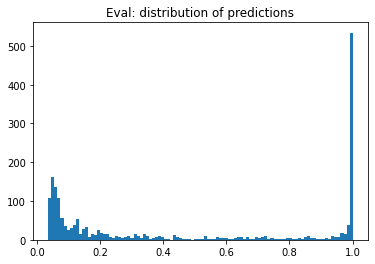

In [17]:
preds, targets, signal_strength, X_eval = evaluate(model, dl_eval, return_X=True)[2:]
plt.title('Eval: distribution of predictions')
_ = plt.hist(preds, bins=100)

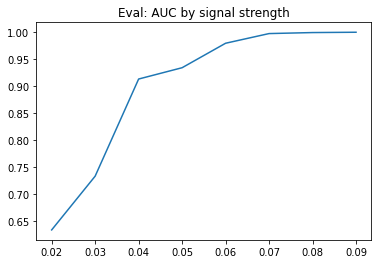

In [18]:
ss_buckets = np.linspace(SIGNAL_LOW, SIGNAL_HIGH, 9)

scores = []
for ss1, ss2 in zip(ss_buckets[:-1], ss_buckets[1:]):
    bucket = np.where((ss1 < signal_strength) & (signal_strength <= ss2))
    score = roc_auc_score(targets[bucket], preds[bucket])
    scores.append(score)

plt.title('Eval: AUC by signal strength')
plt.plot(ss_buckets[:-1], scores)

## Eval set: positive prediction examples

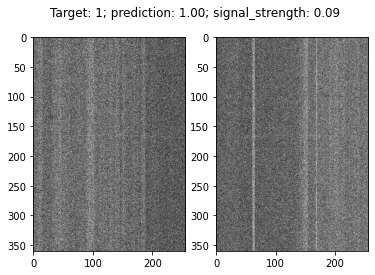

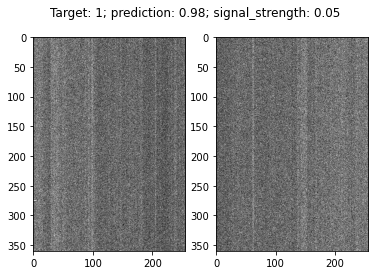

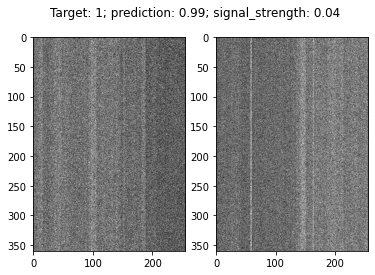

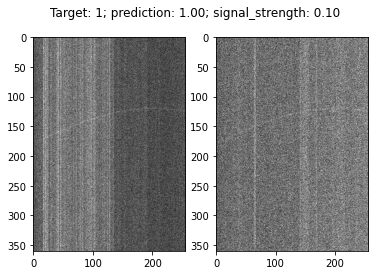

In [19]:
idx = preds > 0.8
for X, y, pred, ss in list(zip(X_eval[idx], targets[idx], preds[idx], signal_strength[idx]))[:4]:
    plt.figure()
    plt.suptitle(f'Target: {y}; prediction: {pred:.02f}; signal_strength: {ss:.02f}')
    plt.subplot(121).imshow(X[0], cmap='gray')
    plt.subplot(122).imshow(X[1], cmap='gray')

## Eval set: negative prediction examples

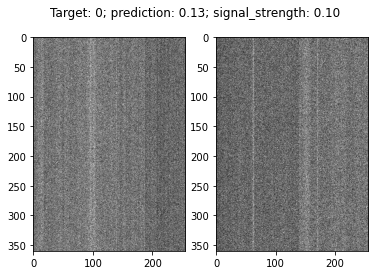

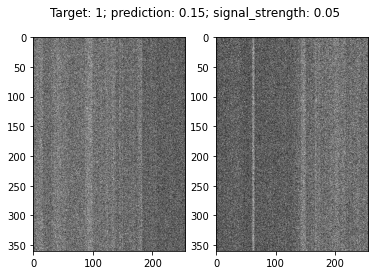

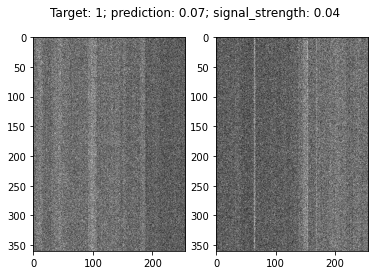

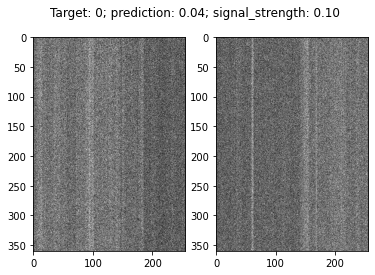

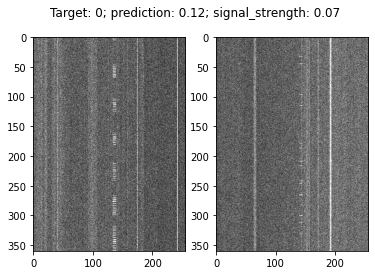

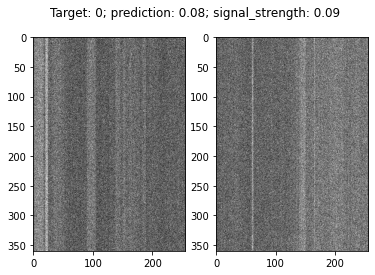

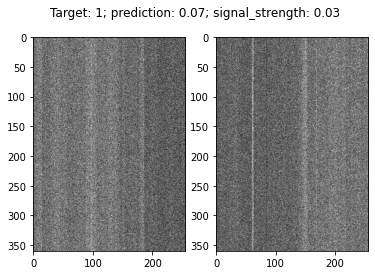

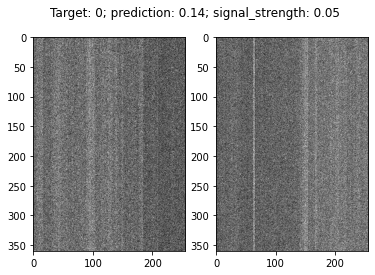

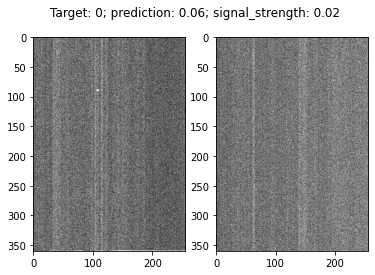

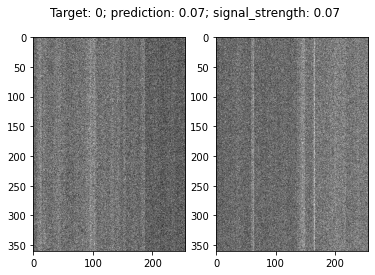

In [20]:
idx = preds < 0.2
for X, y, pred, ss in list(zip(X_eval[idx], targets[idx], preds[idx], signal_strength[idx]))[:10]:
    plt.figure()
    plt.suptitle(f'Target: {y}; prediction: {pred:.02f}; signal_strength: {ss:.02f}')
    plt.subplot(121).imshow(X[0], cmap='gray')
    plt.subplot(122).imshow(X[1], cmap='gray')

# Prediction

## Generate test PNGs

In [21]:
import pandas as pd
df_test = pd.read_csv('/kaggle/input/g2net-winning-strategy-with-external-data/test.csv').query('is_generated_noise == False')
df_test

id  is_generated_noise
3     42a3b2de1               False
6     4ec4b6776               False
7     1031d1f36               False
11    79a0e8448               False
16    6d16d5a37               False
...         ...                 ...
7951  abb05d238               False
7954  e963d2358               False
7956  1ae654ef8               False
7960  a8591701b               False
7973  20da3bfe4               False

[1497 rows x 2 columns]

In [22]:
import pathlib
import h5py

# Utility to read hdf5 file
def read_data(file):
    file = pathlib.Path(file)
    with h5py.File(file, "r") as f:
        filename = file.stem
        f = f[filename]
        h1 = f["H1"]
        l1 = f["L1"]
        freq_hz = list(f["frequency_Hz"])
        
        h1_stft = h1["SFTs"][()]
        h1_timestamp = h1["timestamps_GPS"][()]
        # H2 data
        l1_stft = l1["SFTs"][()]
        l1_timestamp = l1["timestamps_GPS"][()]
        
        return [h1_stft, h1_timestamp],            [l1_stft, l1_timestamp], np.array(freq_hz)
        
if DEBUG:
    [h1_sft, h1_ts], [l1_sft, l1_ts], freq = read_data('/kaggle/input/g2net-detecting-continuous-gravitational-waves/test/00054c878.hdf5')

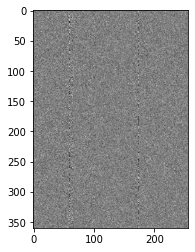

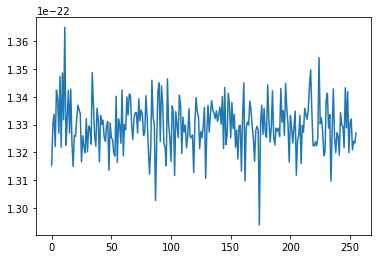

In [23]:
def sft_to_img(sft, ts, buckets=256):
    bucket_size = (ts.max() - ts.min()) // buckets
    idx = np.searchsorted(ts, [ts[0] + bucket_size * i for i in range(buckets)])
    # 1. ASD
    sft = np.absolute(sft)    
    # 2. shrink
    global_noise_amp = np.mean(sft, axis=1)
    img = np.stack([
        np.mean(i, axis=1) if i.shape[1] > 0 else global_noise_amp for i in np.array_split(sft, idx[1:], axis=1) 
    ])    
    ts_noise = img.mean(axis=1)
    # 3. Normalize
    mean, std = np.mean(img), np.std(img.astype(np.float64))
    # print(mean, std)    

    img = img - mean
    img = img / std / 4.9  # different 
    img *= 128 
    img += 128
    # img = img * (255 / np.max(img))
    img = np.clip(img, 0, 255).astype(np.uint8)
    # print(np.min(img), np.max(img), np.mean(img), np.std(img))
    return img.T, ts_noise


if DEBUG:
    img, ts_noise = sft_to_img(h1_sft, h1_ts)
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.figure()
    plt.plot(ts_noise)

  0%|          | 0/1497 [00:00<?, ?it/s]

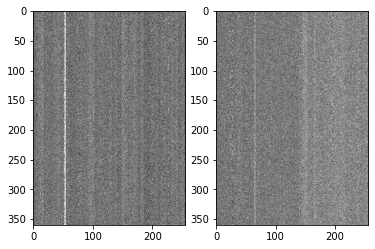

  0%|          | 1/1497 [00:00<18:06,  1.38it/s]

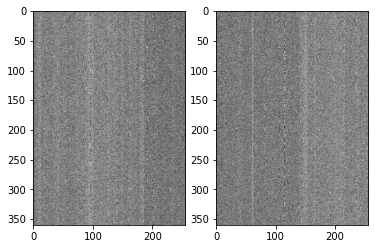

  0%|          | 2/1497 [00:01<18:30,  1.35it/s]

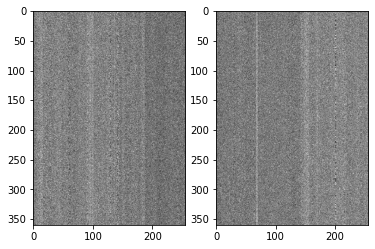

  0%|          | 3/1497 [00:02<17:01,  1.46it/s]

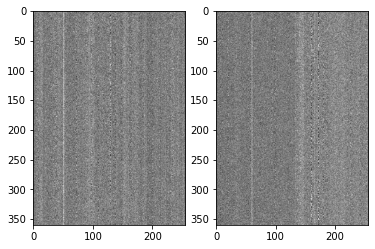

  0%|          | 4/1497 [00:02<16:47,  1.48it/s]

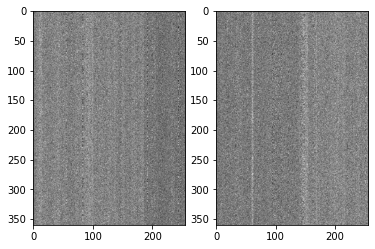

100%|██████████| 1497/1497 [06:59<00:00,  3.57it/s]


In [24]:
import cv2

!mkdir -p data/test_png
for idx, (i, r) in enumerate(tqdm(df_test.iterrows(), total=len(df_test))):
    if not os.path.exists(f'data/test_png/{r.id}_h1.png'):
        [h1_sft, h1_ts], [l1_sft, l1_ts], freq = read_data(f'/kaggle/input/g2net-detecting-continuous-gravitational-waves/test/{r.id}.hdf5')
        h1 = sft_to_img(h1_sft, h1_ts)[0]
        l1 = sft_to_img(l1_sft, l1_ts)[0]
        cv2.imwrite(f'data/test_png/{r.id}_h1.png', h1)
        cv2.imwrite(f'data/test_png/{r.id}_l1.png', l1)    
    if DEBUG and idx < 5:
        plt.subplot(121).imshow(Image.open(f'data/test_png/{r.id}_h1.png'), cmap='gray')
        plt.subplot(122).imshow(Image.open(f'data/test_png/{r.id}_l1.png'), cmap='gray')
        plt.show()

## Run Prediction

In [25]:
import pandas as pd
df_test = pd.read_csv('/kaggle/input/g2net-winning-strategy-with-external-data/test.csv').query('is_generated_noise == False')
df_test

id  is_generated_noise
3     42a3b2de1               False
6     4ec4b6776               False
7     1031d1f36               False
11    79a0e8448               False
16    6d16d5a37               False
...         ...                 ...
7951  abb05d238               False
7954  e963d2358               False
7956  1ae654ef8               False
7960  a8591701b               False
7973  20da3bfe4               False

[1497 rows x 2 columns]

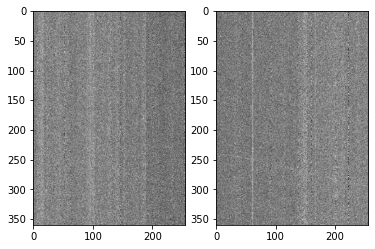

In [26]:
class G2NETDataset(Dataset):
    def __init__(self, df, image_path) -> None:
        self.df = df
        self.image_path = image_path
        self.transforms = get_transforms()

    def __getitem__(self, index):
        id = self.df.iloc[index].id
        img = np.concatenate([self.transforms(Image.open(f'{self.image_path}/{id}_h1.png')),
            self.transforms(Image.open(f'{self.image_path}/{id}_l1.png'))])
        return img

    def __len__(self):
        return len(self.df)



ds_test = G2NETDataset(df_test, 'data/test_png/')

if DEBUG:
    X = ds_test[42]
    plt.subplot(121).imshow(X[0], cmap='gray')
    plt.subplot(122).imshow(X[1], cmap='gray')

In [27]:

dl_test = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())


with torch.no_grad():
    fold_preds = []
    for fold in tqdm(FOLDS, desc='Fold prediction'):
        gc.collect()
        torch.cuda.empty_cache()
        
        model = load_model(fold)
        preds = torch.concat([torch.sigmoid(model(X.to(DEVICE))).cpu() for X in tqdm(dl_test)], dim=0).numpy()
        fold_preds.append(preds)

preds = np.stack(fold_preds).squeeze().mean(axis=0)

Fold prediction: 100%|██████████| 5/5 [00:40<00:00,  8.15s/it]


In [28]:
df_test['target'] = preds
df_test

id  is_generated_noise    target
3     42a3b2de1               False  0.126984
6     4ec4b6776               False  0.348951
7     1031d1f36               False  0.152264
11    79a0e8448               False  0.107961
16    6d16d5a37               False  0.071302
...         ...                 ...       ...
7951  abb05d238               False  0.035130
7954  e963d2358               False  0.077547
7956  1ae654ef8               False  0.044096
7960  a8591701b               False  0.091895
7973  20da3bfe4               False  0.042582

[1497 rows x 3 columns]

In [29]:
df_test.to_csv("single_model.csv")

<AxesSubplot:ylabel='Frequency'>

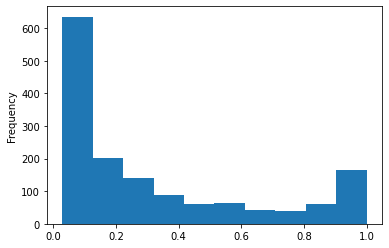

In [30]:
df_test.target.plot.hist()

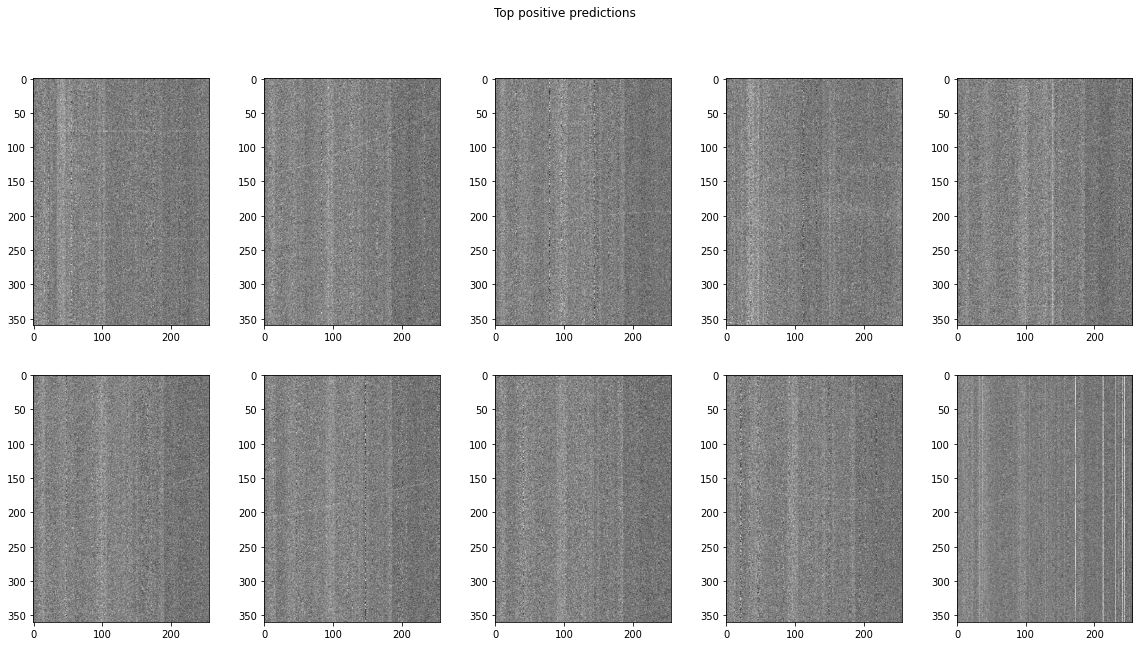

In [31]:
plt.figure(figsize=(20, 10))
plt.suptitle('Top positive predictions')
plt.tight_layout()
for idx, id in enumerate(df_test.sort_values('target').tail(10)['id']):
    plt.subplot(2, 5, idx + 1).imshow(cv2.imread(f'data/test_png/{id}_h1.png'))

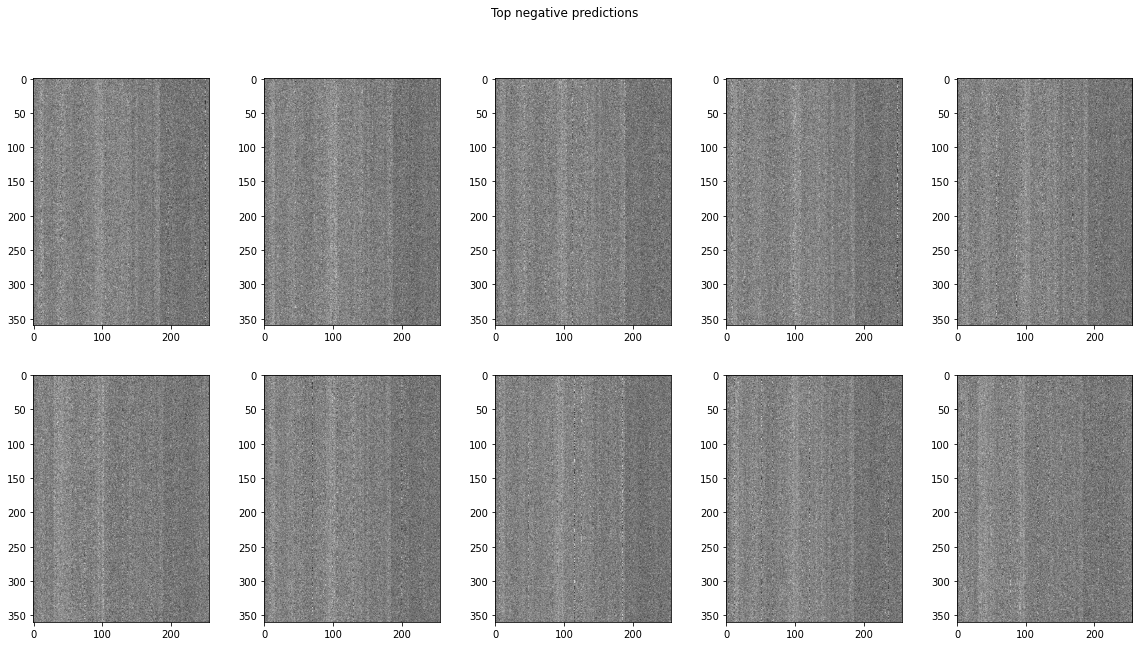

In [32]:
plt.figure(figsize=(20, 10))
plt.suptitle('Top negative predictions')
plt.tight_layout()
for idx, id in enumerate(df_test.sort_values('target').head(10)['id']):
    plt.subplot(2, 5, idx + 1).imshow(cv2.imread(f'data/test_png/{id}_h1.png'))

# Submission + ensemble

In [33]:
# df_test = df_test.set_index('id')
df_sub = pd.read_csv('/kaggle/input/iknowblendingisnotagoodpracticeonkaggle/submission.csv').set_index('id')
df_sub.loc[df_test.id, 'target'] =  (df_test.set_index('id').target + df_sub.loc[df_test.id, 'target']) / 2
df_sub

target
id                 
00054c878  0.275437
0007285a3  0.788003
00076c5a6  0.251232
001349290  0.349471
001a52e92  0.522376
...             ...
ffbce04ef  0.877061
ffc2d976b  0.272746
ffc905909  0.232165
ffe276f3e  0.279939
fffa17f67  0.254878

[7975 rows x 1 columns]

# From https://www.kaggle.com/code/tanreinama/eliminate-noise-using-signal-similarity
r = []
for i, t in zip(df_sub.index, df_sub.target):
    if i in ["308417080", "dc2aaaee9", "8b180f74f", "698567d90"]:
        r.append(1.0)
    else:
        if t < 0.05:
            t = 0.0
        elif t > 0.95:
            t = 1.0
        r.append(t)
df_sub["target"] = r
df_sub.to_csv("submission.csv", index=False)

In [34]:
df_sub.to_csv('submission.csv')

!rm -rf data wandb

**Smash that like button and subscribe for more jaw-dropping notebooks!**